# Labo 7 : classification de textes (pour la désambiguïsation lexicale)
Nathan Gonzalez Montes & Guidoux Vincent

## Objectif et plan

L’objectif de ce laboratoire est d’utiliser des méthodes d’apprentissage supervisé pour classifier des occurrences du mot interest selon leur sens : c’est la même tâche, avec les mêmes données, que le labo 6. Pour classifier les occurrences, on considère leur contexte (mots voisins), et on applique l’approche bayésienne vue en cours : on entraîne un classifieur à six classes (les six sens de interest annotés de 1 à 6) sur une partie des données et on le teste sur la partie restante.

Dans ce laboratoire, on explore deux façons différentes de coder les traits (features) pour cette tâche. Dans les deux cas, on entraînera un NaiveBayesClassifier fourni par NLTK.1 Les deux façons sont :
1. Constituer un vocabulaire des mots qui apparaissent dans le voisinage de interest et définir ces mots comme traits. Pour chaque occurrence de interest, on extrait la valeur de ces traits sous la forme `{(‘rate’ : True), (‘in’ : False), … }` et on ajoute la classe (de 1 à 6).
2. Si word-1 est le mot précédant l’occurrence de interest, on définit comme traits word-n, …, word-2, word-1, word+1, word+2, …, word+n (une fenêtre de taille 2n autour de interest). Les valeurs possibles de ces traits sont cette fois-ci les mots observés, ou ‘NONE’ si la fenêtre dépasse les limites de la phrase. Pour chaque occurrence de interest, on extrait la valeur de ces traits sous la forme `{(‘word-1’ : ‘his’), (‘word+1’ : ‘in’), … }` et on ajoute la classe (de 1 à 6).

Dans les deux cas, il faut diviser les 2368 occurrences de interest en un jeu d’entraînement et un jeu de test, en respectant la proportion initiale de chaque sens. Puis on entraîne un classifieur bayésien naïf en respectant le format de données indiqué par NLTK2, et on teste la performance du classifieur entraîné. L’objectif est de trouver les paramètres qui conduisent aux meilleurs scores de WSD.

## Importation

In [1]:
import nltk.tokenize
import nltk
nltk.download('punkt')
import numpy as np
import re
import random
import time
import pylab as plt
import matplotlib
%matplotlib inline

[nltk_data] Downloading package punkt to /home/trefle/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Liste des noms propres, ponctuation :

## Étapes proposées

### A. Traits lexicaux : présence ou absence de mots dans le voisinage de interest

#### 1. Le fichier de données se trouve à http://www.d.umn.edu/~tpederse/data.html – chercher « interest » vers la fin de la page, et prendre le fichier marqué comme « original format without POS tags » (le même qu’au labo 6). Lire le fichier et générer une liste de listes de mots (une liste par phrase) appelée `tokenized_sentences`.

In [2]:
ponctuations = [',', '.', '`', '\'','-', ';', ':', ')', '&', '{', '(', '}', '=']

In [3]:
filepath = 'data/interest-original.txt' 

try:  
    fp = open(filepath, 'r',encoding="utf-8")
    raw_sentences = fp.read()
finally:  
    fp.close()
    
# for ponct in ponctuations:
#     raw_sentences = raw_sentences.replace(ponct, ' ') # remove the ponctuations

# raw_sentences = re.sub(' [0-9]+', '', raw_sentences) # remove all the digits 

raw_sentences = raw_sentences.split('\n$$\n') # split in sentences

raw_sentences = raw_sentences[:-1] # The last sentence is empty

tokenized_sentences = [nltk.word_tokenize(sent) for sent in raw_sentences] 

print("Il y a {} phrases ".format(len(tokenized_sentences)))

Il y a 2368 phrases 


#### 2. Définir une variable `window_size`, par exemple égale à 3 (on la fera varier plus tard), et une liste vide de mots `word_list`. Parcourir les `tokenized_sentences` et pour chaque phrase ajouter les mots voisins de interest (i.e. situés à une distance inférieure ou égale à `window_size`) dans la liste de mots `word_list`. Combien de mots contient celle-ci à la fin ? Tokens ou types ?

In [4]:
def windowation(tokenized_sentences, windows_size):
    
    word_dict = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []} # Ne sert à rien, sauf à savoir combien il y a de mots par sens
    vocabulary = set() # rassemble tous les types 
    word_list = [] # rassemble tous les tokens
       
    for sentence in (tokenized_sentences):  
        interest_pos = None # position du mot "interest" dans la phrase
        current_sens = None # sens courant du mot interest
        
        for sens_i in range(1,7): # Ce n'est pas la meilleure manière de faire pour trouver "interest"
            current_sens = sens_i
            if "interest_{}".format(sens_i) in sentence:
                interest_pos = sentence.index("interest_{}".format(sens_i))
                break
            elif "interests_{}".format(sens_i) in sentence:
                interest_pos = sentence.index("interests_{}".format(sens_i))
                break
                
        if interest_pos != None:
            
            for index in range(-windows_size, windows_size+1):
                current_index = index + interest_pos
                if current_index > 0 and current_index < len(sentence) and index != 0:
                    current_word = sentence[current_index]
                    word_dict[current_sens].append(current_word)
                    vocabulary.add(current_word)
                    word_list.append(current_word)
        else:
            print("ERREUR - Cette phrase n'a pas d'occurance de interest_?")
            
    return (word_dict, vocabulary, word_list)

In [5]:
windows_size = 3

word_dict, vocabulary, word_list = windowation(tokenized_sentences, windows_size)

In [6]:
occurence_n = 0

for i in range(1,7):
    current_list = word_dict[i]
    current_list_length = len(current_list)
    print("word_list {} : {}".format(i, current_list_length))
    occurence_n += current_list_length

word_list 1 : 2034
word_list 2 : 66
word_list 3 : 341
word_list 4 : 985
word_list 5 : 2847
word_list 6 : 7030


In [7]:
print("nombre total d'occurances(tokens) : {}".format(occurence_n))
print("nombre de mots différents(types) : {}".format(len(vocabulary)))

nombre total d'occurances(tokens) : 13303
nombre de mots différents(types) : 2358


#### 3. À l’aide d’un objet `NLTK` de type `FreqDist`, sélectionner parmi les mots de `word_list` les `N` plus fréquents, dans une nouvelle liste appelée `vocabulary` (p.ex. `N = 500`, mais on le fera varier). Affichez les 50 mots les plus fréquents. Est-ce une bonne idée d’enlever les stopwords ?

In [8]:
N = 500
vocabulary = nltk.FreqDist(word_list).most_common(N)
vocabulary = np.array(vocabulary)
vocabulary = vocabulary[:, 0] # Nous ne gardons que la première colonne

In [9]:
nltk.FreqDist(word_list).most_common(50)

[('in', 759),
 ('rates', 623),
 ('the', 597),
 (',', 509),
 ('and', 385),
 ('to', 364),
 ('.', 362),
 ('of', 325),
 ('a', 257),
 ('on', 165),
 ('rate', 139),
 ("'s", 132),
 ('%', 131),
 ('its', 131),
 ('payments', 112),
 ('are', 100),
 ('that', 98),
 ('has', 93),
 ('``', 92),
 ('lower', 86),
 ('for', 85),
 ('with', 79),
 ('an', 79),
 ('is', 70),
 ('by', 70),
 ('have', 68),
 ('will', 65),
 ('high', 63),
 ('at', 62),
 ('short', 61),
 ('from', 57),
 ('annual', 48),
 ('their', 47),
 ('company', 46),
 ('minority', 46),
 ('or', 45),
 ('foreign', 45),
 ('which', 44),
 ('u.s.', 43),
 ('higher', 43),
 ('bonds', 41),
 ('income', 41),
 ('as', 41),
 ("n't", 40),
 ('short-term', 38),
 ('pay', 38),
 ('other', 38),
 ('below', 35),
 ('buying', 34),
 ('it', 33)]

**Est-ce une bonne idée d’enlever les stopwords ?**
> blabla

#### 4. Parcourir à nouveau les `tokenized_sentences` et pour chaque phrase créer un couple (dictionnaire, sens), où le dictionnaire regroupe les traits et leurs valeurs, et le sens est un nombre de 1 à 6 indiquant le sens de interest. Les couples pour toutes les phrases seront rassemblés dans une liste appelée `feature_sets`.
- Prendre modèle sur https://www.nltk.org/book/ch06.html (début du 1.2)
- Pour le dictionnaire, il faut créer un trait pour chaque mot de vocabulary, et examiner si ce mot est présent dans une fenêtre de taille window_size autour de l’occurrence de interest : si oui, le trait est True, sinon il est False. Par exemple, on aboutit à : {'contains(the)': False, 'contains(,)': True, 'contains(rates)': True, …}.
- Ajouter aussi le trait ‘word0’ qui note si l’occurrence est interest ou interests (pluriel).

In [10]:
def gender_features(sentence, windows_size, vocabulary):
    
    feature_set = {}
    current_sens = None
    word0 = False
    
    for def_i in range(1,7):
        current_sens = def_i
        current_interest = "interest_{}".format(def_i)
        current_interests = "interests_{}".format(def_i)
        if current_interest in sentence:
            i = sentence.index(current_interest)
            break
        elif current_interests in sentence:
            i = sentence.index(current_interests)
            word0 = True
            break
            
    feature_set['word0'] = word0
    
    if i != None:
        neighbours = []
        for index in range(-windows_size, windows_size+1):
            current_index = index + i
            if current_index > 0 and current_index < len(sentence) and index != 0:
                neighbours.append(sentence[current_index])
        for trait in vocabulary:
            if trait in neighbours:
                feature_set[trait] = True
            else:
                feature_set[trait] = False
            
    else:
        print("ERROR")
    return (feature_set,current_sens)

In [11]:
feature_sets = []

for sentence in tokenized_sentences:
    feature_sets.append(gender_features(sentence, windows_size, vocabulary))
len(feature_sets)

2368

##### 4.3 Combien d’occurrences pour chaque sens de interest y a-t-il dans feature_sets ?

In [12]:
occurrences = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}
somme = 0
for feature_set in feature_sets:
    occurrences[feature_set[1]] += 1

In [13]:
occurrences

{1: 361, 2: 11, 3: 66, 4: 178, 5: 500, 6: 1252}

#### 5. Diviser les données de feature_sets en deux sous-ensembles : l’un comportant 80% des données est le `train_set`, et l’autre (20%) est le `test_set`. Attention, il faut respecter deux conditions :
- Mélanger avec shuffle() les occurrences avant de prendre les 80% premières pour le `train_set`et les 20% restantes dans le test_set.
- Chaque sens doit être présent dans les mêmes proportions dans train_set et dans test_set (donc il faut faire la division de manière séparée pour chaque sens).

In [14]:
def separate_train_test(feature_sets):

    random.shuffle(feature_sets)

    occurence_in_train = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}
    train_set = []
    test_set = []
    for feature_set in feature_sets:
        current_sens = feature_set[1]
        if occurence_in_train[current_sens] < (occurrences[current_sens] * 0.8):
            train_set.append(feature_set)
            occurence_in_train[current_sens] += 1
        else:
            test_set.append(feature_set)
    return (train_set, test_set)

In [15]:
train_set, test_set = separate_train_test(feature_sets)

print("Il y a {} couples dans train et {} dans test".format(len(train_set), len(test_set)))

Il y a 1896 couples dans train et 472 dans test


#### 6. Entraîner un classifieur de type `NaiveBayesClassifier` de `NLTK` sur `train_set`

In [16]:
classifier = nltk.NaiveBayesClassifier.train(train_set)

**puis le tester sur les données de `test_set`. Quelle est la précision (`accuracy`) atteinte ?**

In [17]:
print("La précision atteinte est de {:.2f}".format(nltk.classify.accuracy(classifier, test_set)))

La précision atteinte est de 0.88


#### 7. Adapter le code précédent pour effectuer plusieurs divisions des données en train et test (par exemple 10), et calculer la moyenne des scores obtenus. Comment se compare cette moyenne avec votre premier résultat ?

In [18]:
def train_test(feature_sets):
    train_set, test_set = separate_train_test(feature_sets)
    classifier = nltk.NaiveBayesClassifier.train(train_set)
    accuracy = nltk.classify.accuracy(classifier, test_set)
    return accuracy

In [19]:
N_iteration = 10
accuracies = []
for iteration in range(N_iteration):
    print("-----itération n°{}-----".format(iteration))
    accuracies.append(train_test(feature_sets))

-----itération n°0-----
-----itération n°1-----
-----itération n°2-----
-----itération n°3-----
-----itération n°4-----
-----itération n°5-----
-----itération n°6-----
-----itération n°7-----
-----itération n°8-----
-----itération n°9-----


In [20]:
print("la moyenne des scores obtenus est de {:.2f} ".format(np.mean(accuracies)))

la moyenne des scores obtenus est de 0.88 


#### 8. Cherchez les meilleurs paramètres pour la taille de la fenêtre (p.ex. 1, 3, 5, 7, 11) et la taille du vocabulaire (50, 100, 200, 500, 1000 mots). Combien d’expériences faut-il exécuter ? Quelle est la meilleure combinaison fenêtre x vocabulaire et quel est le score moyen obtenu ?

In [21]:
N_iteration = 10
windows_sizes = [3,4,5,6,7]
# windows_sizes = [1,3]
vocabulary_sizes =[100, 200, 350, 500, 750, 1000]
# vocabulary_sizes =[50,100]

In [22]:
scores = np.empty((len(windows_sizes),len(vocabulary_sizes)),dtype=float)
np.shape(scores)

(5, 6)

In [23]:
for i, windows_size in enumerate(windows_sizes):
    for j, vocabulary_size in enumerate(vocabulary_sizes):
        start = time.time()
        
        word_dict, vocabulary, word_list = windowation(tokenized_sentences, windows_size)
        
        somme = 0
        
        for sens_i in range(1,7):
            current_list = word_dict[sens_i]
#             print("word_list {} : {}".format(i, len(current_list)))
            somme += len(current_list)
        
#         print("nombre total d'occurances : {}".format(somme))
#         print("nombre de mots différents : {}".format(len(vocabulary)))
        
        vocabulary = nltk.FreqDist(word_list).most_common(N)
        vocabulary = np.array(vocabulary)
        vocabulary = vocabulary[:, 0]
        
        feature_sets = []

        for sentence in tokenized_sentences:
            feature_sets.append(gender_features(sentence, windows_size, vocabulary))
        len(feature_sets)
        
        occurrences = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}
        for feature_set in feature_sets:
            occurrences[feature_set[1]] += 1
        
        train_set, test_set = separate_train_test(feature_sets)
#         print("Il y a {} couples dans train et {} dans test".format(len(train_set), len(test_set)))
        
        accuracies = []
        for iteration in range(N_iteration):
            accuracies.append(train_test(feature_sets))
            
        current_accuracy = np.mean(accuracies)
        
        scores[i][j] = current_accuracy
        
        end = time. time()

        execution_time = end-start
        print("windows_size : {}; vocabulary_size {}; score : {:.3f} en {:.0f} secondes".format(windows_size, vocabulary_size, current_accuracy, execution_time))

windows_size : 3; vocabulary_size 100; score : 0.887 en 46 secondes
windows_size : 3; vocabulary_size 200; score : 0.888 en 47 secondes
windows_size : 3; vocabulary_size 350; score : 0.881 en 49 secondes
windows_size : 3; vocabulary_size 500; score : 0.885 en 47 secondes
windows_size : 3; vocabulary_size 750; score : 0.883 en 47 secondes
windows_size : 3; vocabulary_size 1000; score : 0.890 en 46 secondes
windows_size : 4; vocabulary_size 100; score : 0.891 en 47 secondes
windows_size : 4; vocabulary_size 200; score : 0.892 en 47 secondes
windows_size : 4; vocabulary_size 350; score : 0.890 en 47 secondes
windows_size : 4; vocabulary_size 500; score : 0.884 en 47 secondes
windows_size : 4; vocabulary_size 750; score : 0.887 en 47 secondes
windows_size : 4; vocabulary_size 1000; score : 0.882 en 47 secondes
windows_size : 5; vocabulary_size 100; score : 0.892 en 47 secondes
windows_size : 5; vocabulary_size 200; score : 0.888 en 47 secondes
windows_size : 5; vocabulary_size 350; score :

In [24]:
scores

array([[0.88728814, 0.88792373, 0.8809322 , 0.88516949, 0.88262712,
        0.88983051],
       [0.89110169, 0.89152542, 0.89004237, 0.88432203, 0.88665254,
        0.88199153],
       [0.89216102, 0.88834746, 0.88305085, 0.88241525, 0.88241525,
        0.88474576],
       [0.87711864, 0.87944915, 0.87669492, 0.88389831, 0.88262712,
        0.88368644],
       [0.88538136, 0.88961864, 0.8809322 , 0.88813559, 0.88432203,
        0.88983051]])

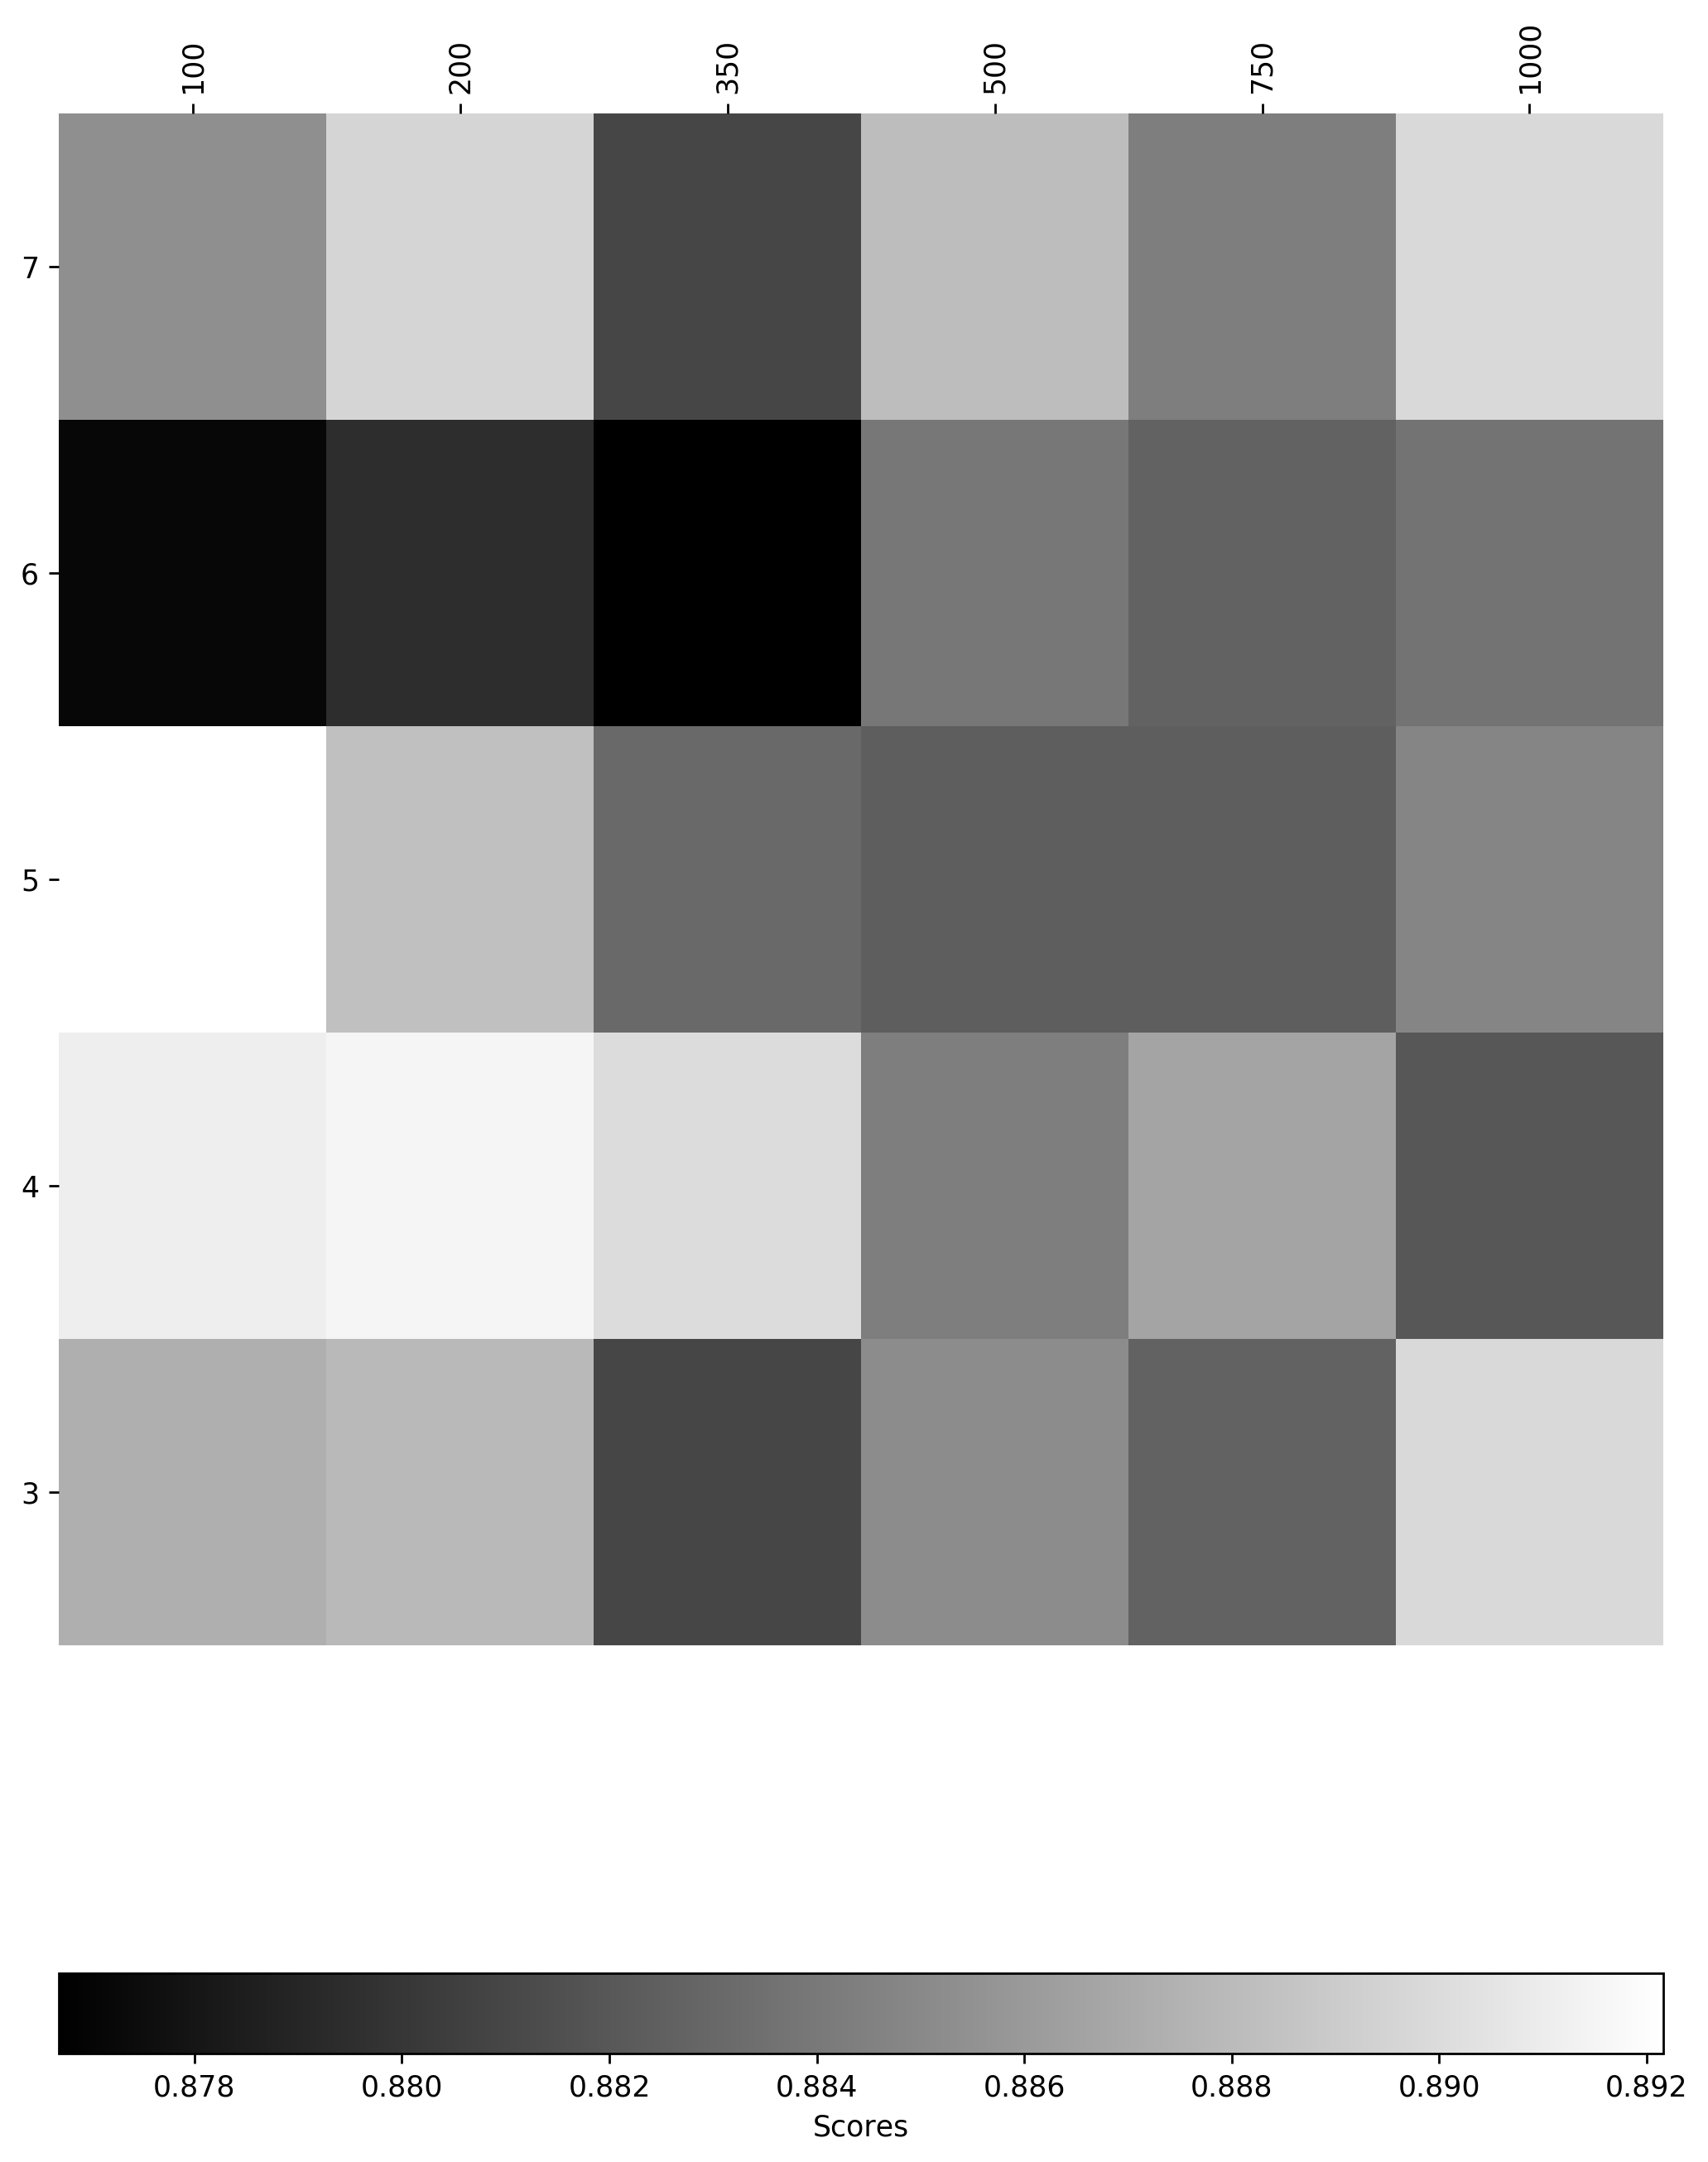

In [25]:
# plot
fig, ax = plt.subplots(num=None,figsize=(10,14),dpi=250) 
heatmap = ax.pcolor(scores, cmap=plt.cm.gray)

ax.set_xticks(np.arange(scores.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(scores.shape[0])+0.5, minor=False)

ax.set_frame_on(False)
ax.xaxis.tick_top()
ax.grid(False)
plt.xlim([0,np.shape(scores)[1]])

ax.set_yticklabels(windows_sizes, minor=False) 
ax.set_xticklabels(vocabulary_sizes, minor=False)

plt.xticks(rotation=90) # rotate xlabels
matplotlib.rcParams['xtick.labelsize'] = 10

cbar = fig.colorbar(heatmap, orientation='horizontal')
cbar.set_label('Scores')

### B. Traits lexicaux positionnels : valeurs des mots précédant/suivant interest
Pour cette deuxième partie, on réutilisera beaucoup d’éléments de la première. Seule la nature des
traits utilisés et leur extraction vont changer.

#### 1. Partir de la liste de listes de mots (une liste par phrase) précédente, appelée tokenized_sentences.

In [26]:
# tokenized_sentences

#### 2. Définir une variable window_size2, par exemple égale à 3 (on la fera varier plus tard).

In [27]:
window_size2 = 3

#### 3. Parcourir les tokenized_sentences et pour chaque phrase créer un couple (dictionnaire, sens), où le dictionnaire regroupe les traits et leurs valeurs, et le sens est un nombre de 1 à 6 indiquant le sens de interest. Les couples pour toutes les phrases seront rassemblés dans une nouvelle liste appelée feature_sets2.

In [28]:
def dict_wind_features(sentence, window_size):
    feature_set = {}
    current_sens = None
    word0 = ""
    
    for def_i in range(1,7):
        current_sens = def_i
        current_interest = "interest_{}".format(def_i)
        current_interests = "interests_{}".format(def_i)
        
        if current_interest in sentence:
            j = sentence.index(current_interest)
            word0 = "interest"
            break
        elif current_interests in sentence:
            j = sentence.index(current_interests)
            word0 = "interests"
            break
    
    feature_set['word0'] = word0
    
    if j != None:
        neighbours = []
        word_index = 10
        
        for index in range(-window_size, window_size + 1):
            word_index = index
            current_index = index + j
            
            if index != 0:
                if current_index > 0 and current_index < len(sentence):
                    feature_set['word{}'.format(word_index)] = sentence[current_index]
                else:
                    feature_set['word{}'.format(word_index)] = None
    else:
        print("ERROR")
    
    return (feature_set, current_sens)

##### 3.1 Pour le dictionnaire de traits, il faut cette fois-ci créer un trait pour chaque position relative par rapport à interest, donc ‘word-1’, ‘word+1’, etc. (jusqu’à window_size2). La valeur du trait sera le mot trouvé à cette position, ou ‘NONE’ si on sort de la phrase. Par exemple {(‘word-1’ : ‘his’), (‘word+1’ : ‘in’), … }.

In [29]:
feature_sets2 = []

for sentence in tokenized_sentences:
    feature_sets2.append(dict_wind_features(sentence, window_size2))

print("(Definition, sens)", feature_sets2[0])

(Definition, sens) ({'word0': 'interest', 'word-3': 'further', 'word-2': 'declines', 'word-1': 'in', 'word1': 'rates', 'word2': '.', 'word3': None}, 6)


##### 3.2 Ajouter aussi le trait ‘word0’ qui note si l’occurrence est interest ou interests (pluriel).

In [30]:
for i, wind in enumerate(feature_sets2):
    print(i, wind)

0 ({'word0': 'interest', 'word-3': 'further', 'word-2': 'declines', 'word-1': 'in', 'word1': 'rates', 'word2': '.', 'word3': None}, 6)
1 ({'word0': 'interest', 'word-3': 'to', 'word-2': 'indicate', 'word-1': 'declining', 'word1': 'rates', 'word2': 'because', 'word3': 'they'}, 6)
2 ({'word0': 'interest', 'word-3': 'rises', 'word-2': 'in', 'word-1': 'short-term', 'word1': 'rates', 'word2': '.', 'word3': None}, 6)
3 ({'word0': 'interest', 'word-3': 'a', 'word-2': '83.4', 'word-1': '%', 'word1': 'in', 'word2': 'this', 'word3': 'energy-services'}, 5)
4 ({'word0': 'interests', 'word-3': 'holding', 'word-2': 'company', 'word-1': 'with', 'word1': 'in', 'word2': 'the', 'word3': 'mechanical'}, 5)
5 ({'word0': 'interest', 'word-3': 'refunded', 'word-2': ',', 'word-1': 'plus', 'word1': '.', 'word2': None, 'word3': None}, 6)
6 ({'word0': 'interest', 'word-3': 'curry', 'word-2': 'set', 'word-1': 'the', 'word1': 'rate', 'word2': 'on', 'word3': 'the'}, 6)
7 ({'word0': 'interest', 'word-3': 'country', 

1312 ({'word0': 'interest', 'word-3': 'gains', 'word-2': 'to', 'word-1': 'strong', 'word1': 'in', 'word2': 'women', 'word3': "'s"}, 1)
1313 ({'word0': 'interests', 'word-3': None, 'word-2': None, 'word-1': None, 'word1': ',', 'word2': 'which', 'word3': 'currently'}, 5)
1314 ({'word0': 'interest', 'word-3': 'britain', 'word-2': "'s", 'word-1': 'high', 'word1': 'rates', 'word2': '.', 'word3': None}, 6)
1315 ({'word0': 'interest', 'word-3': 'there', 'word-2': 'has', 'word-1': 'been', 'word1': 'in', 'word2': 'acquiring', 'word3': 'b.'}, 1)
1316 ({'word0': 'interest', 'word-3': 'hooker', 'word-2': "'s", 'word-1': 'majority', 'word1': 'in', 'word2': 'the', 'word3': 'specialty'}, 5)
1317 ({'word0': 'interest', 'word-3': 'sold', 'word-2': 'its', 'word-1': 'majority', 'word1': 'in', 'word2': 'parisian', 'word3': 'inc.'}, 5)
1318 ({'word0': 'interest', 'word-3': 'failed', 'word-2': 'to', 'word-1': 'make', 'word1': 'payments', 'word2': 'in', 'word3': 'june'}, 6)
1319 ({'word0': 'interest', 'word-

#### 4. Diviser les données de feature_sets2 en deux sous-ensembles (80%/20%) appelés train_set2 et test_set2 avec la même procédure qu’à la partie A.

In [31]:
train_set2, test_set2 = separate_train_test(feature_sets2)

print("Il y a {} couples dans train et {} dans test".format(len(train_set2), len(test_set2)))

Il y a 1896 couples dans train et 472 dans test


#### 5. Entraîner un classifieur de type NaiveBayesClassifier de NLTK sur train_set2, puis le tester sur les données de test_set2. Quelle est la précision (accuracy) atteinte ?

In [32]:
classifier2 = nltk.NaiveBayesClassifier.train(train_set2)

print("La précision atteinte est de {:.5f}".format(nltk.classify.accuracy(classifier2, test_set2)))

La précision atteinte est de 0.87500


#### 6. Effectuer plusieurs divisions des données en train et test (par exemple 10), et calculer la moyenne des scores obtenus. Comment se compare cette moyenne avec votre premier résultat ?

In [33]:
N_iteration = 10
accuracies = []
for iteration in range(N_iteration):
    print("-----itération n°{}-----".format(iteration))
    accuracies.append(train_test(feature_sets2))

-----itération n°0-----
-----itération n°1-----
-----itération n°2-----
-----itération n°3-----
-----itération n°4-----
-----itération n°5-----
-----itération n°6-----
-----itération n°7-----
-----itération n°8-----
-----itération n°9-----


In [34]:
print("la moyenne des scores obtenus est de {:.5f} ".format(np.mean(accuracies)))

la moyenne des scores obtenus est de 0.87818 


#### 7. Cherchez les meilleurs paramètres pour la taille de la fenêtre (p.ex. entre 1 et 15). Quelle est la meilleure valeur et quel est le score moyen obtenu ?

In [35]:
window_size3 = 0
N_iteration2 = 10
accuracies2 = []
feature_sets3 = []

results = {}

for idx in range(1, 16):
    results[idx] = []
    print("Window size:", idx)
    window_size3 = idx
    for sentence in tokenized_sentences:
        feature_sets3.append(dict_wind_features(sentence, window_size3))
    
    for iteration in range(N_iteration2):
        print("-----Itération n°{}-----".format(iteration))
        current_accuracy = train_test(feature_sets3)
        accuracies2.append(current_accuracy)
        results[idx].append(current_accuracy)

Window size: 1
-----Itération n°0-----
-----Itération n°1-----
-----Itération n°2-----
-----Itération n°3-----
-----Itération n°4-----
-----Itération n°5-----
-----Itération n°6-----
-----Itération n°7-----
-----Itération n°8-----
-----Itération n°9-----
Window size: 2
-----Itération n°0-----
-----Itération n°1-----
-----Itération n°2-----
-----Itération n°3-----
-----Itération n°4-----
-----Itération n°5-----
-----Itération n°6-----
-----Itération n°7-----
-----Itération n°8-----
-----Itération n°9-----
Window size: 3
-----Itération n°0-----
-----Itération n°1-----
-----Itération n°2-----
-----Itération n°3-----
-----Itération n°4-----
-----Itération n°5-----
-----Itération n°6-----
-----Itération n°7-----
-----Itération n°8-----
-----Itération n°9-----
Window size: 4
-----Itération n°0-----
-----Itération n°1-----
-----Itération n°2-----
-----Itération n°3-----
-----Itération n°4-----
-----Itération n°5-----
-----Itération n°6-----
-----Itération n°7-----
-----Itération n°8-----
----

In [36]:
best_accuracy = np.mean(results[1])
best_idx = 1

for idx in range(1, 16):
    if best_accuracy < np.mean(results[idx]):
        best_accuracy = np.mean(results[idx])
        best_idx = idx
    
    print("Accuracy for windows_size = {} : {:0.5f}".format(idx, np.mean(results[idx])))

print("Le meilleur des scores obtenus est de la fenêtre {} avec une valeur de {:.5f} ".format(best_idx, best_accuracy))

Accuracy for windows_size = 1 : 0.86695
Accuracy for windows_size = 2 : 0.88592
Accuracy for windows_size = 3 : 0.89038
Accuracy for windows_size = 4 : 0.89262
Accuracy for windows_size = 5 : 0.89067
Accuracy for windows_size = 6 : 0.88951
Accuracy for windows_size = 7 : 0.88117
Accuracy for windows_size = 8 : 0.87916
Accuracy for windows_size = 9 : 0.87426
Accuracy for windows_size = 10 : 0.86932
Accuracy for windows_size = 11 : 0.86661
Accuracy for windows_size = 12 : 0.86457
Accuracy for windows_size = 13 : 0.86235
Accuracy for windows_size = 14 : 0.86151
Accuracy for windows_size = 15 : 0.85926
Le meilleur des scores obtenus est de la fenêtre 4 avec une valeur de 0.89262 


In [37]:
print("La moyenne des scores totale obtenus est de {:.5f} ".format(np.mean(accuracies2)))

La moyenne des scores totale obtenus est de 0.87562 


#### 8. Quelle est le meilleur score obtenu entre (A) et (B) ?

#### 9. Thème de réflexion facultatif : les différences des scores sont-elles statistiquement significatives ?

Merci d’envoyer votre notebook Jupyter par email au professeur avant le **vendredi 31 mai à 23h59**.